## 第8章 モデルの作り方（応用）

#### 準備

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import numpy as np, pandas as pd, networkx as nx
import matplotlib.pyplot as plt
from random import shuffle
from collections import defaultdict
from itertools import combinations, product
from more_itertools import chunked, first, pairwise
from more_itertools import iterate, take
from PIL import Image, ImageDraw
from urllib import request
from pulp import LpProblem, LpMaximize, LpBinary, LpStatus
from pulp import lpDot, lpSum, value
from ortoolpy import addvar, addvars, addvals, addbinvar
from ortoolpy import addbinvars, model_max, model_min, tsp
from japanmap import adjacent, pref_map, pref_code as pc

### 8.1 野球選手の守備を決めよう

In [2]:
np.random.seed(0)
w = np.random.randint(1, 10, (9, 9))  # 適性
g = nx.Graph()
for i, j in product(range(9), range(9)):
    g.add_edge(i, j + 9, weight=-w[i][j])
r = dict(nx.max_weight_matching(g, maxcardinality=True))
r.update(dict(zip(r.values(), r.keys())))  # 逆方向
[r[i] - 8 for i in range(9)]  # 選手ごとの守備

[2, 5, 6, 4, 9, 1, 3, 7, 8]

### 8.2 県を4色に塗り分けよう

In [3]:
m = LpProblem()
vlst = addbinvars(47, 4)  # 変数
for i in range(47):
    m += lpSum(vlst[i]) == 1  # 色の割当
    for j in adjacent(i+1):
        for c in range(4):
            # 隣接していたら、同色は1つまで
            m += vlst[i][c] + vlst[j-1][c] <= 1
m.solve()

1

In [4]:
cols = [['red', 'blue', 'green', 'yellow']
        [int(value(lpDot(range(4), v)))] for v in vlst]
pref_map(range(1, 48), cols=cols, width=3)

### 8.3 画像ファイルを4色で塗ろう

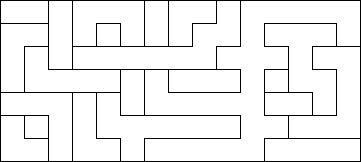

In [5]:
im = Image.open('data/four_color.png')
im

In [6]:
# 各エリアをRGB=(0,1,通し番号)で塗りつぶす
n = 0
for y, x in product(range(im.height), range(im.width)):
    if im.getpixel((x, y)) != (255, 255, 255, 255):  # 白
        continue
    ImageDraw.floodfill(im, (x, y), (0, 1, n, 255))
    n += 1
# 境界を消す
dd = [(-1, 0), (0, -1), (0, 1), (1, 0)]
l = list(product(range(1,im.height-1),range(1,im.width-1)))
shuffle(l)
for y, x in l:
    c = im.getpixel((x, y))
    if c[:2] == (0, 1):  # 対象エリア
        for i, j in dd:
            if im.getpixel((x + i, y + j))[:2] != (0, 1):
                im.putpixel((x + i, y + j), c)

In [7]:
g = nx.Graph()  # グラフ
for y, x in product(range(im.height-1), range(im.width-1)):
    c1 = im.getpixel((x, y))
    if c1[:2] != (0, 1):
        continue
    c2 = im.getpixel((x+1, y))
    c3 = im.getpixel((x, y+1))
    if c2[:2] == (0, 1) and c1[2] != c2[2]:
        g.add_edge(c1[2], c2[2])
    if c3[:2] == (0, 1) and c1[2] != c3[2]:
        g.add_edge(c1[2], c3[2])

In [8]:
m = LpProblem() # 数理モデル
# エリアiを色jにするかどうか
vlst = addbinvars(g.number_of_nodes(), 4)
for i in g.nodes():
    m += lpSum(vlst[i]) == 1  # 色を割当
for i, j in g.edges():
    for k in range(4):
        m += vlst[i][k] + vlst[j][k] <= 1  # 隣接
m.solve()

1

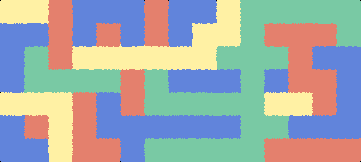

In [9]:
co = [(97, 132, 219, 255), (228, 128, 109, 255),
      (255, 241, 164, 255), (121, 201, 164, 255)] # 4色
cols = [int(value(lpDot(range(4), v))) for v in vlst]
for y, x in product(range(im.height-1), range(im.width-1)):
    c = im.getpixel((x, y))
    if c[:2] == (0, 1):  # エリアならば、結果で塗る
        ImageDraw.floodfill(im, (x, y), co[cols[c[2]]])
im

### 8.4 デートコースを決めよう

In [10]:
# パラメーター
atra = ('入口 喫茶 ボート カップ レストラン 観覧車 '
        'お化け屋敷 コースター 迷路').split()
prio = [0, 50, 36, 45, 79, 55, 63, 71, 42]  # 満足度
tims = [0, 20, 28, 15, 35, 17, 18, 14, 22]  # 滞在時間
n = len(atra)
# アトラクション表
dfa = pd.DataFrame(
    list(zip(atra, prio, tims)),
    columns=['アトラクション', '満足度', '滞在時間'])
dfa[:3]  # 先頭3行

,アトラクション,満足度,滞在時間
0,入口,0,0
1,喫茶,50,20
2,ボート,36,28


In [11]:
timm = [[0, 1, 9], [0, 3, 7], [0, 4, 12], [1, 2, 11],
    [1, 3, 12], [1, 4, 7], [1, 5, 13], [2, 4, 14],
    [2, 5, 8], [3, 4, 11], [3, 6, 7], [3, 7, 12],
    [4, 5, 9], [4, 6, 13], [4, 7, 9], [4, 8, 13],
    [5, 7, 13], [5, 8, 7], [6, 7, 7], [7, 8, 6]]
# 移動時間表
dft = pd.DataFrame(
    [c for i, j, t in timm for c in [(i, j, t), (j, i, t)]],
    columns=['I', 'J', '移動時間'])
dft[:8:2]  # 1行おきに表示

,I,J,移動時間
0,0,1,9
2,0,3,7
4,0,4,12
6,1,2,11


In [12]:
def solve_route(dfa, dft, limit_time, lower=0):
    """
    入口（index=0）から複数のアトラクションをまわり時間内に
        満足度最大のものを選ぶ
    入力
        dfa: 催し物表（アトラクション,満足度,滞在時間）
        dft: 移動時間表（I:点i, J:点j, 移動時間）
        limit_time: 制限時間
        lower: 最低アトラクション数
    出力
        満足度の和、時間、利用順序
    """
    dfa, dft = dfa.copy(), dft.sort_values(['I', 'J'])
    m = LpProblem(sense=LpMaximize)
    dfa['VarS'] = [1] + addvars(n - 1)  # 催し物を選ぶか
    dft['VarIJ'] = addbinvars(len(dft))  # IからJに行くか
    # JからIに行くか
    dft['VarJI'] = dft.sort_values(['J', 'I']).VarIJ.values
    u = [0] + addvars(n - 1)  # 入口から何番目か
    m += lpDot(dfa.満足度, dfa.VarS)  # 目的関数
    e = (lpDot(dfa.滞在時間, dfa.VarS)
       + lpDot(dft.移動時間, dft.VarIJ))
    m += e <= limit_time  # 制限時間
    for _, r in dfa.iterrows():
        # 選んだら来る
        m += r.VarS == lpSum(dft[dft.J == r.name].VarIJ)
    for _, v in dft.groupby('I'):
        m += lpSum(v.VarIJ) == lpSum(v.VarJI)  #入ったら出る
    qry = dft.query('I!=0 & J!=0')
    for _, (i, j, _, vij, vji) in qry.iterrows():
        m += u[i] + 1 - (n - 1) * (1 - vij) + (
            n - 3) * vji <= u[j]  # 持ち上げポテンシャル制約
    for _, (_,j,_,v0j,vj0) in dft.query('I==0').iterrows():
        # 持ち上げ下界制約
        m += 1 + (1 - v0j) + (lower - 3) * vj0 <= u[j]
    for _, (i,_,_,vi0,v0i) in dft.query('J==0').iterrows():
        # 持ち上げ上界制約
        m += u[i] <= (n - 1) - (1 - vi0) - (n - 3) * v0i
    m.solve()
    if m.status != 1:
        return -1, -1, []
    dft['ValIJ'] = dft.VarIJ.apply(value)
    dc = dict(dft[dft.ValIJ > 0.5].values[:, :2])
    return value(m.objective), value(e), [
        dfa.アトラクション[i] for i in take(
            int(value(lpSum(dfa.VarS))) + 1,
            iterate(lambda k: dc[k], 0))
    ]
solve_route(dfa, dft, 200)

(405.0,
 200.0,
 ['入口', 'カップ', 'お化け屋敷', 'コースター', '迷路', '観覧車', 'レストラン', '喫茶', '入口'])

### 8.5 巡視船の航路を決めよう

In [13]:
nt = 6 * 24  # 時間数(10分刻みで24時間分)
N = 10  # 10x10のマス
np.random.seed(1)
# 時間帯ごとエリアごとの発見確率
df = pd.DataFrame(np.random.rand(nt, N*N))
df = np.log(1 - df) # 見つからない確率(1 - df)のlogをとる
df -= df.min().min() # 最小値を0にする
g = nx.Graph() # ノード = 時刻×N*N＋マス番号
for t, *r in df.itertuples():
    for i, j in product(range(N), range(N)):
        k1 = t*N*N + i*N + j
        for di,dj in [(-1,0), (0,-1), (0,0), (0,1), (1,0)]:
            if 0 <= i+di < N and 0 <= j+dj < N:
                k2 = (i+di)*N + j+dj
                # 時空間ネットワークの接続をする
                g.add_edge(k1, (t+1)*N*N+k2, weight=r[k2])
# 最短路を求める
res = np.array(nx.dijkstra_path(g, 0, nt*N*N))

In [14]:
plt.rcParams['figure.figsize'] = 5, 1.8

/Users/knt/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


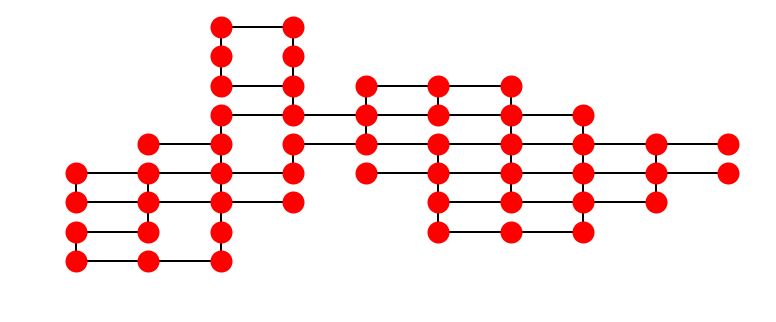

In [15]:
h = nx.Graph()
h.add_edges_from([(i, j) for i, j in pairwise(res%(N*N))])
pos = {(i*N+j):(i,j) for i in range(N) for j in range(N)}
nx.draw(h, pos=pos, node_size=100)

### 8.6 学区編成問題

In [16]:
本州 = np.arange(2, 36)
代表点 = {pc('青森'): 7, pc('山梨'): 21, pc('山口'): 6}
代表以外  = set(本州) - 代表点.keys()
g = nx.DiGraph()  # グラフ作成
g.add_nodes_from(代表点, demand=0)
g.add_nodes_from(代表以外, demand=-1)
for i, dem in 代表点.items():
    nwl = i * 100  # 本州の複製用
    g.add_nodes_from(nwl+本州, demand=0)
    g.node[nwl+i]['demand'] = dem-1
    g.add_edges_from((j, nwl+j) for j in 代表以外)
    g.add_edges_from(((nwl+j, nwl+k) for j in 本州
                      for k in adjacent(j)), weight=1)
res = nx.min_cost_flow(g)

In [17]:
dc = dict(zip(代表点,['red','yellow','orange']))
dc.update({i: dc[j // 100] for i, t in res.items()
           for j, v in t.items() if v and i < 100})
pref_map(本州, cols=[dc[i] for i in 本州], width=4)

### 8.7 ゲーム理論の混合戦略

In [18]:
def game(pr):
    m = LpProblem(sense=LpMaximize)  # 数理モデル
    xyz = addvars(3)  # 変数 x,y,z
    w = addvar(lowBound=None)  # 変数 w
    m += w  # 目的関数
    m += lpSum(xyz) == 1  # 制約条件
    for i in range(3):
        m += lpDot(pr[:, i], xyz) >= w  # 制約条件
    m.solve()  # 求解
    print(value(w), [value(v) for v in xyz])
pr = np.array([[0, 4, -1], [-1, 0, 1], [1, -1, 0]]) # 利得表
game(pr)

0.16666667 [0.16666667, 0.33333333, 0.5]


In [19]:
game(-pr.T)

-0.16666667 [0.33333333, 0.16666667, 0.5]


### 8.8 最長しりとりを求める

In [20]:
kws = """\
alignas,alignof,and,and_eq,asm,auto,bitand,bitor,bool,
break,case,catch,char,char16_t,char32_t,class,compl,const,
constexpr,const_cast,continue,decltype,default,delete,do,
double,dynamic_cast,else,enum,explicit,export,extern,false,
float,for,friend,goto,if,inline,int,long,mutable,namespace,
new,noexcept,not,not_eq,nullptr,operator,or,or_eq,private,
protected,public,register,reinterpret_cast,return,short,
signed,sizeof,static,static_assert,static_cast,struct,
switch,template,this,thread_local,throw,true,try,typedef,
typeid,typename,union,unsigned,using,virtual,void,volatile,
wchar_t,while,xor,xor_eq""".replace('\n', '').split(',')
g = nx.MultiDiGraph()  # 単語グラフ
g.add_nodes_from(['start', 'end'])
for kw in kws:
    g.add_edge(kw[0], kw[-1], word=kw, var=addbinvar())
for nd in list(g.node)[2:]:
    g.add_edge('start', nd, word='', var=addbinvar())
    g.add_edge(nd, 'end', word='', var=addbinvar())

In [21]:
df = pd.DataFrame([(fr, to, k, d['word'], d['var'])
    for (fr, to, k), d in g.edges.items()],
    columns=['From', 'To', 'Key', 'Word', 'Var'])
m = LpProblem(sense=LpMaximize)
m += lpSum(df.Var)  # 目的関数
m += lpSum(df[df.From == 'start'].Var) == 1
m += lpSum(df[df.To == 'end'].Var) == 1
for nd in list(g.nodes())[2:]:
    m += (lpSum([t[2] for t in g.in_edges(nd, data='var')])
       == lpSum([t[2] for t in g.edges(nd, data='var')]))
m.solve()  # 求解

1

In [22]:
h = nx.MultiDiGraph()  # 解から新しいグラフを作成
addvals(df)
for row in df[df.Val > 0.5].itertuples():
    h.add_edge(row.From, row.To, word=row.Word)
h.add_edge('end', 'start')  # オイラー閉路に
res = [h[f][t][k]['word'] for f, t, k in list(
    nx.eulerian_circuit(h, 'start', True))[1:-2]]
len(res), ' - '.join(res)

(35,
 'alignas - sizeof - float - throw - wchar_t - thread_local - long - goto - or - register - return - not - typename - else - enum - mutable - extern - noexcept - typeid - do - operator - reinterpret_cast - true - export - template - explicit - typedef - friend - dynamic_cast - this - static - class - signed - default - try')

### 8.9 最短超文字列問題を解く

In [23]:
def dist(s, t):
    """sからtへの距離"""
    ns, nt = len(s), len(t)
    for i in range(ns - nt, ns):
        if s[i:] == t[:ns - i]:
            return nt - ns + i
    return nt
def shortest_superstring(words):
    """最短超文字列問題"""
    words = [''] + words  # 空文字追加
    dst = {(i, j): dist(s, t) for i, s in enumerate(words)
           for j, t in enumerate(words) if i != j}
    _, lst = tsp(words, dst)
    return ''.join(words[j][len(words[j]) - dst[i, j]:]
                   for i, j in pairwise(lst))
shortest_superstring(['ACTA', 'GAC', 'GTC', 'TAG'])

'GACTAGTC'

### 8.10 バラバラの写真を復元せよ！

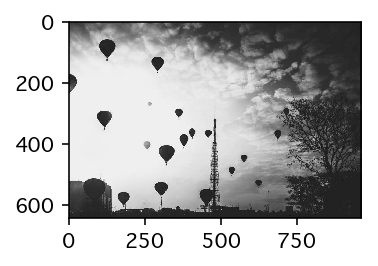

In [24]:
# https://snap-photos.s3.amazonaws.com/img-thumbs/960w/X8CW5LGMWI.jpg
with open('data/image.jpg', 'rb') as fd:
    im = Image.open(fd)  # 写真読込
    ar = np.array(im.convert('L').getdata())
ar = ar.reshape((im.height, -1))
plt.imshow(ar, cmap='gray');  # 表示

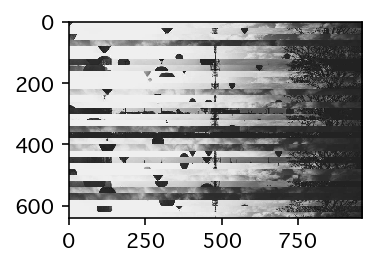

In [25]:
wd = 20  # 短冊の幅
n = im.height // wd  # 分割数
sp = [ar[i * wd:(i + 1) * wd] for i in range(n)]
np.random.seed(0)
np.random.shuffle(sp)
plt.imshow(np.concatenate(sp), cmap='gray');  # バラバラ

In [26]:
nn = int(im.width * 0.5) # 50%を使う
t = [[np.linalg.norm(np.sort(np.abs(sp[i][-1] - sp[j][0]))
    [:nn]) for j in range(n)] for i in range(n)]
d = {(i, j): t[i][j] for i in range(n) for j in range(n)}
lst = tsp(range(n), d)[1]  # 訪問順

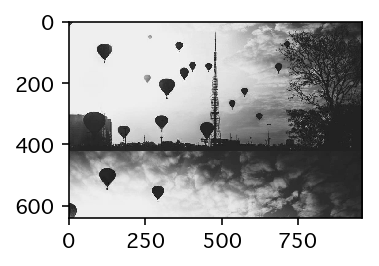

In [27]:
res = [sp[lst[i]] for i in range(n)]
plt.imshow(np.concatenate(res), cmap='gray');

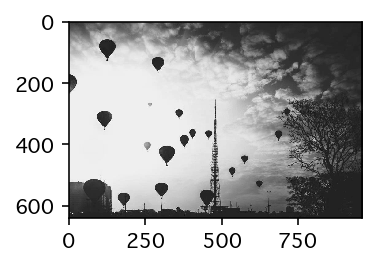

In [28]:
plt.imshow(np.concatenate(res[21:]+res[:21]), cmap='gray');

### 8.11 体育祭の写真選択

In [29]:
ni, nj, nu = 20, 100, 20 # 生徒数, 写真数, 選択する写真数
生徒s = ['生徒%.2d'%i for i in range(1,ni+1)]
np.random.seed(1)
def mkst():
    return set(np.random.choice(生徒s,
        max(1,int(np.random.normal(4,2))), False))
df = pd.DataFrame([('写真%.3d'%j, mkst())
    for j in range(1, nj+1)], columns=['写真', '生徒'])
df[:2] # 最初の2行

,写真,生徒
0,写真001,"{生徒19, 生徒04, 生徒09, 生徒14, 生徒11, 生徒18, 生徒15}"
1,写真002,"{生徒03, 生徒04}"


In [30]:
m = model_max()            # 数理モデル
addbinvars(df)             # 写真ごとの選択
VarY = addvars(ni)         # 生徒ごとの被写体数
Ymin = addvar()            # 最小被写体数
m += 10*Ymin + lpSum(VarY) # 目的関数
m += lpSum(df.Var) == nu   # 選択写真数
for yi, st in zip(VarY, 生徒s):
    m += yi == lpSum(row.Var for row in df.itertuples()
                     if st in row.生徒) # 各生徒の被写体数
    m += Ymin <= yi

In [31]:
def solve_and_show(m, df, VarY, Ymin):
    m.solve()  # 求解
    addvals(df)  # 結果
    ValY = np.vectorize(value)(VarY)  # 結果
    print('%s 最小%d名 平均%.2f名'%
        (LpStatus[m.status], value(Ymin), sum(ValY)/ni))
    return ValY
ValY = solve_and_show(m, df, VarY, Ymin)

Optimal 最小5名 平均6.25名


In [32]:
df[df.Val > 0.5].iloc[:3, :2]  # 最初の3行2列

,写真,生徒
0,写真001,"{生徒19, 生徒04, 生徒09, 生徒14, 生徒11, 生徒18, 生徒15}"
11,写真012,"{生徒19, 生徒02, 生徒09, 生徒18, 生徒07, 生徒10}"
13,写真014,"{生徒02, 生徒09, 生徒12, 生徒16, 生徒06, 生徒18, 生徒03}"


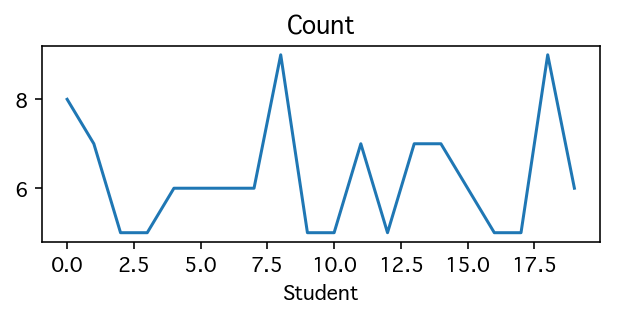

In [33]:
plt.plot(ValY)
plt.xlabel('Student')
plt.title('Count');

In [34]:
for t in chunked(df.itertuples(), 5):  # 各生徒提出の5枚組
    m += lpSum(row.Var for row in t) == 1  # 5枚組から1枚
ValY = solve_and_show(m, df, VarY, Ymin)

Optimal 最小5名 平均5.70名


### 8.12 凸多角形の最適三角形分割

/Users/knt/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


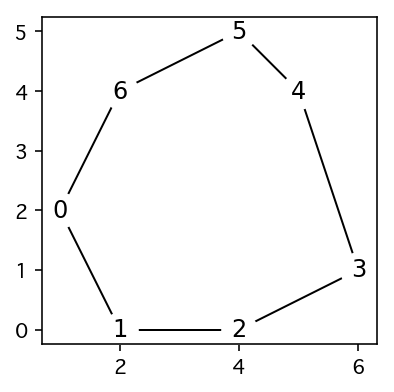

In [35]:
plt.rcParams['figure.figsize'] = 3, 3
plt.axes().set_aspect('equal', 'datalim')  # 縦横等比率
pos = np.array([[1,2],[2,0],[4,0],[6,1],[5,4],[4,5],[2,4]])
dcpos = dict(enumerate(pos))
n = len(pos)
g = nx.Graph()
g.add_edges_from([(i, (i+1) % n) for i in range(n)])
nx.draw_networkx(g, pos=dcpos, node_color='w')

In [36]:
df = pd.DataFrame([(i, j, np.linalg.norm(pos[i] - pos[j]))
    for i in range(n) for j in range(i + 2, n - (i == 0))],
    columns='I J Dist'.split())
addbinvars(df)
df[:2]

,I,J,Dist,Var
0,0,2,3.605551,v001641
1,0,3,5.099020,v001642


In [37]:
m = model_min()
m += lpDot(df.Dist, df.Var)  # 目的関数
m += lpSum(df.Var) == n - 3 # N-3本必要
for idx,i1,j1,_,v1 in df.itertuples():
    for _,i2,j2,_,v2  in df[idx+1:].itertuples():
        if i1 < i2 < j1 < j2:
            m += v1+v2 <= 1 # 交差させない
m.solve()

1

/Users/knt/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


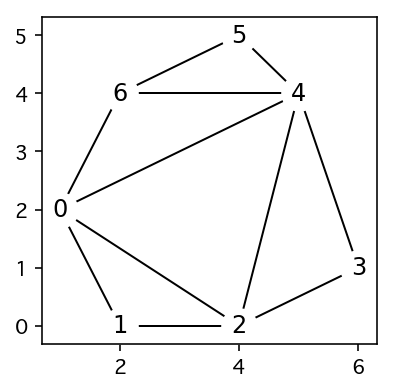

In [38]:
addvals(df)
g.add_edges_from(df[df.Val>0.5].values[:, :2])
nx.draw_networkx(g, pos=dcpos, node_color='w')

### 8.13 エデンの園配置の確認

In [39]:
def checkEden(data):
    ni, nj = len(data), len(data[0])
    df = pd.DataFrame([(i, j, data[i][j] != '.')
        for i in range(ni) for j in range(nj)],
        columns=['行', '列', '値'])
    addbinvars(df)
    m = model_min()
    for row in df.itertuples():
        q = (f'{row.行-1} <= 行 <= {row.行+1}'
            f'&{row.列-1} <= 列 <= {row.列+1}')
        v = lpSum(df.query(q).Var) - row.Var  # 周り8マス
        if row.値:  # 3 <= v+x, 2v+x <= 7
            m += v + row.Var >= 3
            m += 2*v + row.Var <= 7
        else:  # v+x <= 2 or v+x >=4
            y = addbinvar()
            m += v + row.Var <= 2 + 7*y # y==0 → v+x <= 2
            m += v           >= 4*y     # y==1 →   v >= 4
    m.solve()
    return LpStatus[m.status]

In [40]:
checkEden("""\
.##..#.##...
#..##..#.#.#
.#.#.##.#.#.
#....##..##.
.###...#....
..#.#.##.#..
.#.##...#.#.
#....#.#....""".splitlines())

'Infeasible'

### 8.14 麻雀のあがりの判定

In [41]:
def calc(hai):
    cand = []  # 候補
    df = pd.DataFrame(sorted(hai), columns=['V'])
    sp = df.V.value_counts()
    for i in sp[sp >= 2].index:  # 雀頭候補作成
        cand.extend(combinations(df[df.V == i].index, 2))
    n2 = len(cand)  # 候補数
    for i in sp[sp >= 3].index:  # 刻子候補作成
        cand.extend(combinations(df[df.V == i].index, 3))
    c = df.V.unique()
    for i in range(len(c) - 2):  # 順子候補作成
        if c[i + 1] - c[i] == c[i + 2] - c[i + 1] == 1:
            cand.extend(product(df.index[df.V == c[i]],
                                df.index[df.V == c[i+1]],
                                df.index[df.V == c[i+2]]))
    m = LpProblem()  # 数理モデル
    vv = addbinvars(len(cand))  # 変数
    m += lpSum(vv[:n2]) == 1  # 雀頭は1つ
    dlst = [[] for _ in range(14)]  # 牌別候補番号リスト
    for i, ca in enumerate(cand):
        for j in ca:
            dlst[j].append(vv[i])
    for vs in dlst:
        m += lpSum(vs) == 1  # どれかの候補に1つ存在
    if m.solve() != 1:
        return None
    return [[df.V[j] for j in cand[i]] for i, v
            in enumerate(vv) if value(v) > 0.5]

In [42]:
def show(n):
    if n < 30:
        return chr(ord('１') + n % 10) + '萬筒索'[n // 10]
    return '東西南北白発中'[n // 2 - 16]
hai = [0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8]  # 牌
for i in calc(hai):
    for j in i:
        print(show(j), end=' ')
    print()

１萬 １萬 
９萬 ９萬 ９萬 
１萬 ２萬 ３萬 
４萬 ５萬 ６萬 
７萬 ８萬 ９萬 
